# AUEB M.Sc. in Data Science (part-time)

**Course**: Practical Data Science

**Semester**: Fall 2018

**1st homework**: Analyzing Chicago Crime Data

**Author**: Spiros Politis

---

## Homework description

For this homework we will focus in the exploratory analysis part of the Data Science Process. To do so, we will use the [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data). This dataset is quite interesting as it has numerical, text and geo data.

You can choose to work on any subset of the data you want as long as your local machine can handle it comfortably. The full dataset (starting from 2001) has ~6M observations, while the data for 2018 (so far) are ~220K rows. It is recommended that you work on at least 2-3 years of data.

Your objective is to answer the following high-level questions in a user-friendly way. For our purposes, the user can be considered a non-tech Police / FBI official, or a member of the public. High-level - as in real-life scenarios - means ill-defined, possibly vague. Trying to understand what is the best way to answer such questions, can be considered part of the homework too.

### Notes

- There may be multiple (code) paths you can follow to reach the same result. You should follow the appropriate idioms and best practices (e.g. using vectorized operations).
- You should approach the current project as more of a project deliverable - presentation than a course homework. Try to tell a story, rather than handing over just a "solution"

### Submission Instructions

You must submit your homework as a Jupyter notebook that will contain the full code and documentation of how you solved the questions. The Jupyter notebook must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some Pandas and Python knowledge can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

### Honor Code

You understand that this is an individual homework, and as such you must carry it out alone. You may seek help on the Internet, by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the homework and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.

You should be able to justify **why** you wrote that particular line of code.

***

# Homework implementation

## A few remarks on coding practices

- Immutability is preffered: the author tends to avoid "inplace = True" parameters and preffers to work with immutable objects
- Paramater names in Python functions, redundant though they may seem, will be often included for readability
- Try to KISS and DRY :-)

## Required libraries, configuration and global functions

In [2]:
from __future__ import print_function
import sys
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# We need this for palette management
from matplotlib.colors import ListedColormap
import seaborn as sns
from sodapy import Socrata

from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Matplotlib config
%matplotlib inline

# Seaborn config
sns.set(style = "darkgrid")

# Set a random seed so that possible random operations performed by us can be replicated by others.
np.random.seed(19730618)

In [3]:
# Global functions

# Helper function that will redirect printing to stderr.
# Used when printing for exception handling etc.
def print_stderr(*args, **kwargs):
    print(*args, file = sys.stderr, **kwargs)

# Returns the ceiling of a number, rounded according to the 'to' parameter
# i.e. to thousands, to hundred-thousands etc.
def ceiling(num, to = 100000):
    y, z = divmod(num, to)
    
    return int(to * (y + 1))

def normalize(df_column):
    return (df_column - df_column.min()) / (df_column.max() - df_column.min())

## Acquiring data

Chicago crime data can been retrieved from the [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data) by either: 

- (1) a direct download of a dataset in CSV format or
- (2) by making use of the [Socrata Open Data API](https://dev.socrata.com/) API and the corresponding [SODA Python library](https://github.com/xmunoz/sodapy).

For the purpose of this homework, the author chose to use a downloaded CSV file. Method (2) is mentioned at the end of this report (Appendix: Acquiring data by performing SODA API calls), for posterity :-)

### 1 Parsing the CSV data file

This method is the trivial one and preferred, in the context of this homework, since the requirements are pretty much fixed i.e. there is no specific requirement and / or need to retrieve data in a non-static way.

In [4]:
crimes_csv = "city_of_chicago_crimes_2001_to_present.csv"

crimes_df = pd.read_csv(os.getcwd() + "/data/" + crimes_csv, delimiter = ",", header = 0)

## Inspecting, cleaning and transforming the dataset

Let's take a look at the dataset:

In [5]:
crimes_df.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10000092,HY189866,03/18/2015 07:44:00 PM,047XX W OHIO ST,041A,BATTERY,AGGRAVATED: HANDGUN,STREET,False,False,...,28.0,25.0,04B,1144606.0,1903566.0,2015,02/10/2018 03:50:01 PM,41.891399,-87.744385,"(41.891398861, -87.744384567)"
1,10000094,HY190059,03/18/2015 11:00:00 PM,066XX S MARSHFIELD AVE,4625,OTHER OFFENSE,PAROLE VIOLATION,STREET,True,False,...,15.0,67.0,26,1166468.0,1860715.0,2015,02/10/2018 03:50:01 PM,41.773372,-87.665319,"(41.773371528, -87.665319468)"
2,10000095,HY190052,03/18/2015 10:45:00 PM,044XX S LAKE PARK AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,4.0,39.0,08B,1185075.0,1875622.0,2015,02/10/2018 03:50:01 PM,41.813861,-87.596643,"(41.81386068, -87.596642837)"
3,10000096,HY190054,03/18/2015 10:30:00 PM,051XX S MICHIGAN AVE,0460,BATTERY,SIMPLE,APARTMENT,False,False,...,3.0,40.0,08B,1178033.0,1870804.0,2015,02/10/2018 03:50:01 PM,41.800802,-87.622619,"(41.800802415, -87.622619343)"
4,10000097,HY189976,03/18/2015 09:00:00 PM,047XX W ADAMS ST,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,28.0,25.0,03,1144920.0,1898709.0,2015,02/10/2018 03:50:01 PM,41.878065,-87.743354,"(41.878064761, -87.743354013)"


...and its columns:

In [6]:
crimes_df.columns

Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

We can safely **discard** the following columns, not required for our analysis:

- ID
- Case Number
- Block
- IUCR
- Description
- Location Description
- Arrest
- Domestic
- FBI Code
- Year (we will be using a DatetimeIndex, year value is not required)
- Updated On
- Location (we do have latitude and longitude values already)

In [7]:
crimes_df = crimes_df.drop(columns = [
    "ID", 
    "Case Number", 
    "Block", 
    "IUCR", 
    "Description", 
    "Location Description", 
    "Arrest",
    "Domestic",
    "FBI Code", 
    "Year", 
    "Updated On",
    "Location"
])

We also need to 'pythonize' our column names. Previous visual inspection showed that we need to replace spaces and fix capitalization.

In [8]:
# Replace any spaces with underscores
crimes_df.columns = crimes_df.columns.str.replace(" ", "_")

# Make sure we strip any invisible white spaces
crimes_df.columns = crimes_df.columns.str.strip()

# Set all columns names to lower case
crimes_df.columns = crimes_df.columns.str.lower()

...and check:

In [9]:
crimes_df.columns

Index(['date', 'primary_type', 'beat', 'district', 'ward', 'community_area',
       'x_coordinate', 'y_coordinate', 'latitude', 'longitude'],
      dtype='object')

Let us proceed with examining which columns contain null values:

In [10]:
crimes_df.isnull().any()

date              False
primary_type      False
beat              False
district           True
ward               True
community_area     True
x_coordinate       True
y_coordinate       True
latitude           True
longitude          True
dtype: bool

Let us replace null values. We choose to fill nulls instead of droping corrsponding rows making sure, however, that we exclude such values from our analysis. For instance, since we will be using *latitude* and *longitude* for part 3 of the homework, we should make sure to exclude such coordinates.

The rationale behind not dropping rows that contain nulls is that we may loose valuable information (e.g. crime event counts) if we chose to drop an observation based on incomplete information (e.g. missing location location).

In [11]:
crimes_df["beat"] = crimes_df["beat"].fillna(value = 0.0)
crimes_df["district"] = crimes_df["district"].fillna(value = 0.0)
crimes_df["ward"] = crimes_df["ward"].fillna(value = 0.0)
crimes_df["community_area"] = crimes_df["community_area"].fillna(value = 0.0)
crimes_df["x_coordinate"] = crimes_df["x_coordinate"].fillna(value = 0.0)
crimes_df["y_coordinate"] = crimes_df["y_coordinate"].fillna(value = 0.0)
crimes_df["latitude"] = crimes_df["latitude"].fillna(value = 0.0)
crimes_df["longitude"] = crimes_df["longitude"].fillna(value = 0.0)

Check again for nulls in the dataset:

In [12]:
crimes_df.isnull().any()

date              False
primary_type      False
beat              False
district          False
ward              False
community_area    False
x_coordinate      False
y_coordinate      False
latitude          False
longitude         False
dtype: bool

Let us also take a look at the data type of each column, in order to identify columns that need transformation (e.g. dates that have not been automatically converted to datetime objects, reduntant types in terms of accuracy etc.):

In [13]:
for column in crimes_df.columns:
    print("Column name: ", column, " / Data type: ", type(crimes_df[column][0]))

Column name:  date  / Data type:  <class 'str'>
Column name:  primary_type  / Data type:  <class 'str'>
Column name:  beat  / Data type:  <class 'numpy.int64'>
Column name:  district  / Data type:  <class 'numpy.float64'>
Column name:  ward  / Data type:  <class 'numpy.float64'>
Column name:  community_area  / Data type:  <class 'numpy.float64'>
Column name:  x_coordinate  / Data type:  <class 'numpy.float64'>
Column name:  y_coordinate  / Data type:  <class 'numpy.float64'>
Column name:  latitude  / Data type:  <class 'numpy.float64'>
Column name:  longitude  / Data type:  <class 'numpy.float64'>


We can clearly see that the following columns have been loaded with defaults, in terms of their data type:

- *date*: data type is **str**, should be **datetime64**
- *beat*: data type is **float64**, should be **int64**
- *district*: data type is **float64**, should be **int64**
- *ward*: data type is **float64**, should be **int64**
- *community_area*: data type is **float64**, should be **int64**

We should convert the columns to appropriate datatypes for (i) alignment with original dataset types and (ii) performance gains (clearly, using a **numpy.float64** when a **numpy.int64** is required will lower our memory footprint). 

Let's proceed with our transformation:

In [14]:
# Including the date format dramatically increases performance.
crimes_df["date"] = pd.to_datetime(crimes_df["date"], format = "%m/%d/%Y %I:%M:%S %p", utc = True)
crimes_df["beat"] = crimes_df["beat"].astype(np.int64)
crimes_df["district"] = crimes_df["district"].astype(np.int64)
crimes_df["ward"] = crimes_df["ward"].astype(np.int64)
crimes_df["community_area"] = crimes_df["community_area"].astype(np.int64)

As a next step, since we will be mostly working with time series, we need to set a DatetimeIndex on our dataframe:

In [15]:
crimes_df = crimes_df.set_index("date")
crimes_df = crimes_df.sort_index()

...and check:

In [16]:
crimes_df.index

DatetimeIndex(['2001-01-01 00:00:00+00:00', '2001-01-01 00:00:00+00:00',
               '2001-01-01 00:00:00+00:00', '2001-01-01 00:00:00+00:00',
               '2001-01-01 00:00:00+00:00', '2001-01-01 00:00:00+00:00',
               '2001-01-01 00:00:00+00:00', '2001-01-01 00:00:00+00:00',
               '2001-01-01 00:00:00+00:00', '2001-01-01 00:00:00+00:00',
               ...
               '2018-11-11 23:13:00+00:00', '2018-11-11 23:30:00+00:00',
               '2018-11-11 23:30:00+00:00', '2018-11-11 23:30:00+00:00',
               '2018-11-11 23:30:00+00:00', '2018-11-11 23:30:00+00:00',
               '2018-11-11 23:31:00+00:00', '2018-11-11 23:35:00+00:00',
               '2018-11-11 23:50:00+00:00', '2018-11-11 23:50:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=6747040, freq=None)

Finally, we need to **exclude year 2018** for which we have inconclusive data that might introduce bias in our analysis. Therefore, we will chose the range of date between 2001-01-01 and 2017-12-31:

In [17]:
crimes_df = crimes_df.loc['2001-01-01':'2017-12-31']

Our data pre-processing work is now complete, on with the analysis!

## Questions

### 1 Trend Analysis

#### Question

Are there any intra-year (at the month level) and intra-day (at the hour level) trends in the number and type of crimes ? To answer these, you should plot histogram(s) with the appropriate frequencies for each type of crime (you may choose between Primary Type and Description ) and then comment on the results. The solution involves choosing the appropriate number and structure of histograms (e.g. using subplots, stacked bars or not).

#### Answer

In [18]:
# Convert primary_type to a categorical variable
crimes_df["primary_type"] = crimes_df["primary_type"].astype("category")

First things first, let us take a look at the overall trend of crime within the years. We need to get a "feel" for the overall trend in crime in the City of Chicago, so as to reinforce our story-telling:

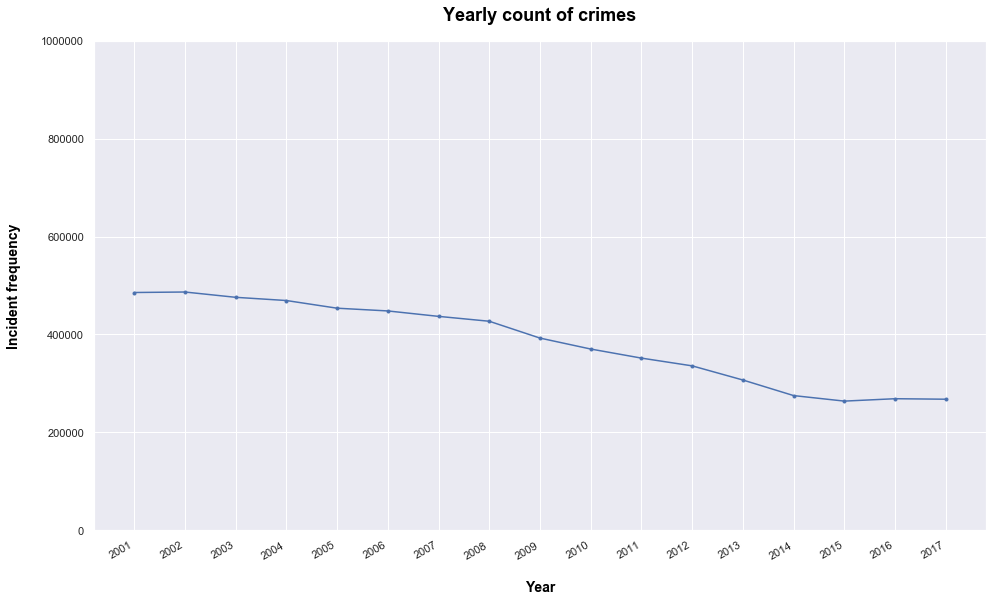

In [19]:
###
# Group our data
##
# Group our data by year
crimes_gb_y = crimes_df.groupby(by = [crimes_df.index.year], axis = 0)

# Count the number of incidents of our grouped set
crimes_gb_y_pt_count = crimes_gb_y["primary_type"].count()

# Get the max crime count so that we can normalize the plotting axis
crimes_gb_y_pt_max = crimes_gb_y_pt_count.max()

###
# Plot our data
##
plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

ax = crimes_gb_y_pt_count.plot(
    kind = "line", 
    marker = ".",
    stacked = False, 
    figsize = (16, 10), 
    use_index = True, 
    legend = False
)

# Normalize the y-axis values
ax.set_ylim(0, ceiling(crimes_gb_y_pt_max, to = 1000000))

# Set graph title
ax.set_title(label = "Yearly count of crimes", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Year", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Incident frequency", fontdict = plot_axis_title_font, labelpad = 20)

# Set x-axis ticks to be the index of our series object
ax.set_xticks(ticks = crimes_gb_y_pt_count.index);

# Auto-format year labels
ax.get_figure().autofmt_xdate();

Clearly, crime rates have fallen dramatically within the span of years we are examining. Let's present the changes numerically:

In [20]:
###
# Compute some statistics
##
# Convert the series to a dataframe
crimes_gb_y_pt_count_df = crimes_gb_y_pt_count.to_frame()

# Compute the per year incident count difference
crimes_gb_y_pt_count_df["diff_from_previous_year"] = crimes_gb_y_pt_count_df["primary_type"].diff(periods = 1)

# Compute the per year incident difference as a percentage
crimes_gb_y_pt_count_df["diff_from_previous_year_perc"] = crimes_gb_y_pt_count_df["primary_type"].pct_change(periods = 1)

crimes_gb_y_pt_count_df

,primary_type,diff_from_previous_year,diff_from_previous_year_perc
date,,,
2001,485749,NaN,NaN
2002,486753,1004.0,0.002067
2003,475936,-10817.0,-0.022223
2004,469381,-6555.0,-0.013773
2005,453703,-15678.0,-0.033401
2006,448097,-5606.0,-0.012356
2007,436999,-11098.0,-0.024767
2008,427038,-9961.0,-0.022794
2009,392663,-34375.0,-0.080496


Let us dive deeper and examine the intra-year (at the month level) and intra-day (at the hour level) trends in the number and type of crimes.

Let us look at the **monthly trends in crime**, per crime class:

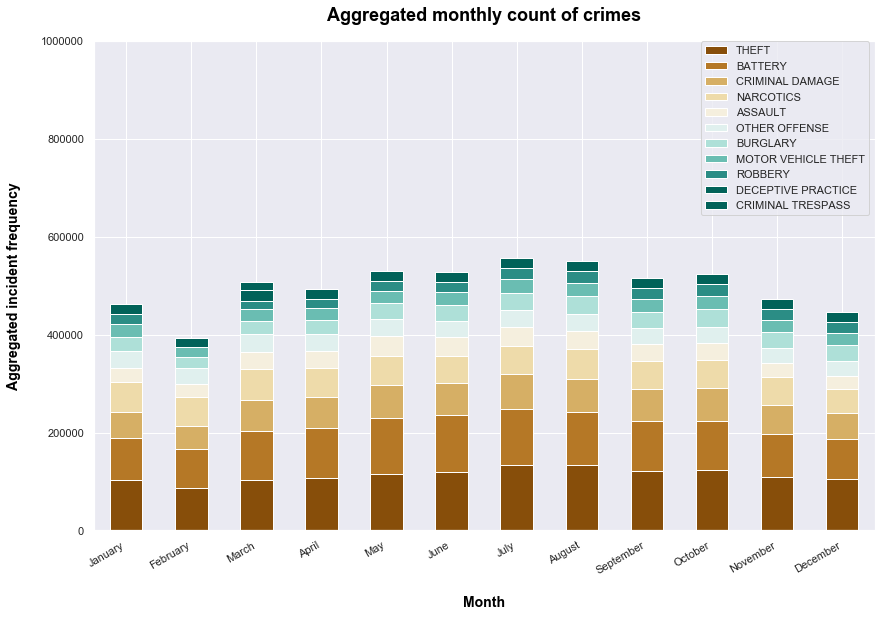

In [21]:
num_primary_types = 10
num_months = 12

###
# Group our data
##
# Group our data by month
crimes_gb_mpt = crimes_df.groupby(by = [crimes_df.index.month, "primary_type"], axis = 0)

# Count the number of incidents of our grouped set
crimes_gb_mpt_pt_count = crimes_gb_mpt["primary_type"].count()

# We may chose to display only some of the crime class, for readability
if num_primary_types != None:
    crimes_gb_mpt_pt_count = crimes_gb_mpt_pt_count.nlargest(num_primary_types * num_months)

crimes_gb_mpt_pt_count_un = crimes_gb_mpt_pt_count.unstack()

###
# Plot our data
##
months = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December",
}

plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

# Since the catecorical variable 'primary_type' has many levels,  
# we are required to create a color map such that different levels
# can be as distinguishable as possible...
cat_cmap = ListedColormap(sns.color_palette("BrBG", 10).as_hex())

ax = crimes_gb_mpt_pt_count_un.plot(
    kind = "bar", 
    stacked = True, 
    figsize = (14, 10), 
    use_index = False, 
    legend = True,
    cmap = cat_cmap
)

# Normalize the y-axis values
ax.set_ylim(0, ceiling(crimes_gb_mpt_pt_count.max(), to = 1000000))

# Set graph title
ax.set_title(label = "Aggregated monthly count of crimes", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Month", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Aggregated incident frequency", fontdict = plot_axis_title_font, labelpad = 20)

# Set x-axis ticks and corresponding labels to be the index of our series object
ax.set_xticks(ticks = crimes_gb_mpt_pt_count.index.levels[0] - 1);
ax.set_xticklabels(labels = [months[x] for x in crimes_gb_mpt_pt_count.index.levels[0]])

# Auto-format year labels
ax.get_figure().autofmt_xdate();

ax.legend(bbox_to_anchor = (1, 1.01));

**Note**: you can tweak the parameter 'num_primary_types' to limit the classes of crimes displayed in the graph above. Setting the parameter to None will provide you with the graph of the entire dataset.

Visual inspection shows seasonality in accumulated crimes which also applies to crime classes. One can clearly see that the month less affected by crime is **February**, whereas crime incidents peak during **July** and **August**.

Another remark is that the most common classes of crime are **theft** and **battery**, with **criminal damage** and **narcotics** cases following close. These four classes account for a large percentage of all crimes.

Let us look at the trends in crime, per crime class, at an hourly level:

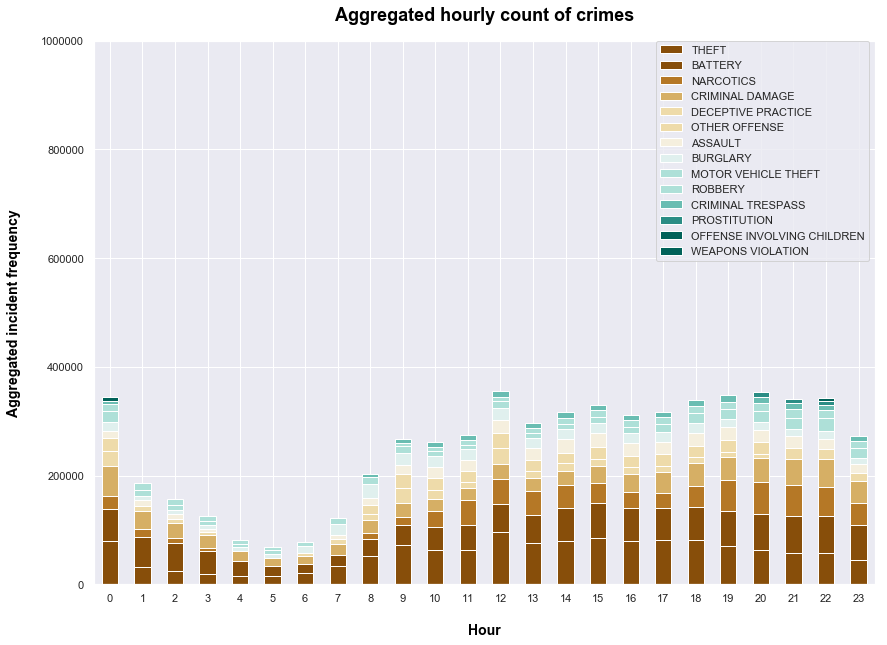

In [22]:
# We need this for palette management
from matplotlib.colors import ListedColormap

num_primary_types = 10
num_hours = 24

###
# Group our data
##
# Group our data by hour
crimes_gb_hpt = crimes_df.groupby(by = [crimes_df.index.hour, "primary_type"], axis = 0)

# Count the number of incidents of our grouped set
crimes_gb_hpt_pt_count = crimes_gb_hpt["primary_type"].count()

# We may chose to display only some of the crime class, for readability
if num_primary_types != None:
    crimes_gb_hpt_pt_count = crimes_gb_hpt_pt_count.nlargest(num_primary_types * num_hours)
    
crimes_gb_hpt_pt_count_un = crimes_gb_hpt_pt_count.unstack()

###
# Plot our data
##
plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

# Since the catecorical variable 'primary_type' has many levels,  
# we are required to create a color map such that different levels
# can be as distinguishable as possible...
cat_cmap = ListedColormap(sns.color_palette("BrBG", 10).as_hex())

ax = crimes_gb_hpt_pt_count_un.plot(
    kind = "bar", 
    stacked = True, 
    figsize = (14, 10), 
    use_index = False, 
    legend = True,
    cmap = cat_cmap
)

# Normalize the y-axis values
ax.set_ylim(0, ceiling(crimes_gb_hpt_pt_count.max(), to = 1000000))

# Set graph title
ax.set_title(label = "Aggregated hourly count of crimes", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Hour", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel(ylabel = "Aggregated incident frequency", fontdict = plot_axis_title_font, labelpad = 20)

# Rotate x-axis labels so as to appear vertical
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.legend(bbox_to_anchor = (1, 1.01));

**Note**: you can tweak the parameter 'num_primary_types' to limit the classes of crimes displayed in the graph above. Setting the parameter to None will provide you with the graph of the entire dataset.

Visual inspection again shows a periodic trend in accumulated crimes. It is evident that the most "quiet" hours are between **01:00 am** and **08:00 am**. This trend follows the same pattern for all crime classes.

**Bonus**

Render some of the above plots in the same figure, by using the [matplotlib.subplots](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html) function. Save the figures in a crime_trends.pdf

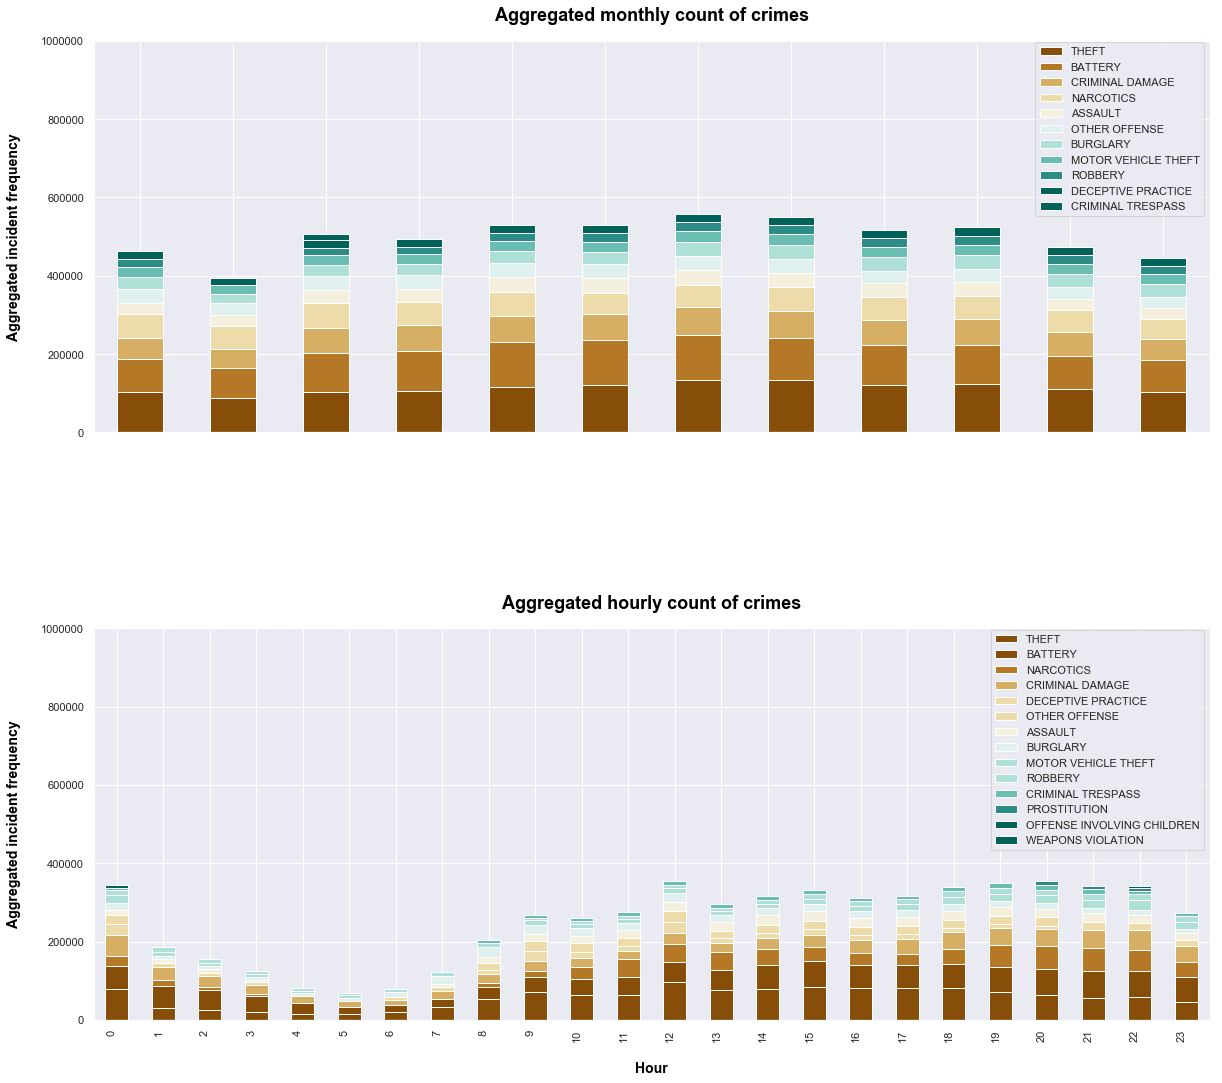

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, squeeze = True)

###
# Plot 1
##
sub_ax_1 = crimes_gb_mpt_pt_count_un.plot(
    kind = "bar", 
    stacked = True, 
    figsize = (20, 20), 
    use_index = False, 
    legend = True,
    cmap = cat_cmap,
    ax = ax1
)

# Normalize the y-axis values
sub_ax_1.set_ylim(0, ceiling(crimes_gb_mpt_pt_count.max(), to = 1000000))

# Set graph title
sub_ax_1.set_title(label = "Aggregated monthly count of crimes", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
sub_ax_1.set_xlabel(xlabel = "Month", fontdict = plot_axis_title_font, labelpad = 20)
sub_ax_1.set_ylabel(ylabel = "Aggregated incident frequency", fontdict = plot_axis_title_font, labelpad = 20)

# Set x-axis ticks and corresponding labels to be the index of our series object
sub_ax_1.set_xticks(ticks = crimes_gb_mpt_pt_count.index.levels[0] - 1);
sub_ax_1.set_xticklabels(labels = [months[x] for x in crimes_gb_mpt_pt_count.index.levels[0]])

# Auto-format year labels
sub_ax_1.get_figure().autofmt_xdate();

sub_ax_1.legend(bbox_to_anchor = (1, 1.01));


###
# Plot 2
##
sub_ax_2 = crimes_gb_hpt_pt_count_un.plot(
    kind = "bar", 
    stacked = True, 
    figsize = (20, 20), 
    use_index = False, 
    legend = True,
    cmap = cat_cmap,
    ax = ax2
);

# Normalize the y-axis values
sub_ax_2.set_ylim(0, ceiling(crimes_gb_hpt_pt_count.max(), to = 1000000))

# Set graph title
sub_ax_2.set_title(label = "Aggregated hourly count of crimes", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
sub_ax_2.set_xlabel(xlabel = "Hour", fontdict = plot_axis_title_font, labelpad = 20)
sub_ax_2.set_ylabel(ylabel = "Aggregated incident frequency", fontdict = plot_axis_title_font, labelpad = 20)

# Rotate x-axis labels so as to appear vertical
for tick in ax.get_xticklabels():
    tick.set_rotation(0)

sub_ax_2.legend(bbox_to_anchor = (1, 1.01))

fig.subplots_adjust(hspace = 0.5)
fig.savefig(fname = "crime_trends.pdf", dpi = 150, papertype = "a4", format = "pdf", facecolor = "w", edgecolor = "b", orientation = "landscape", pad_inches = 3);

### 2 Plotting Heatmaps

#### Question

Another convenient way to spot trends in time-series data is using [Heatmaps](https://en.wikipedia.org/wiki/Heat_map).

"Convert" some of the histograms above to heatmaps to illustrate your observations to the stakeholders. To do so, the x-axis of the histogram should be a time element and the y-axis a frequency count for each crime type.

#### Answer

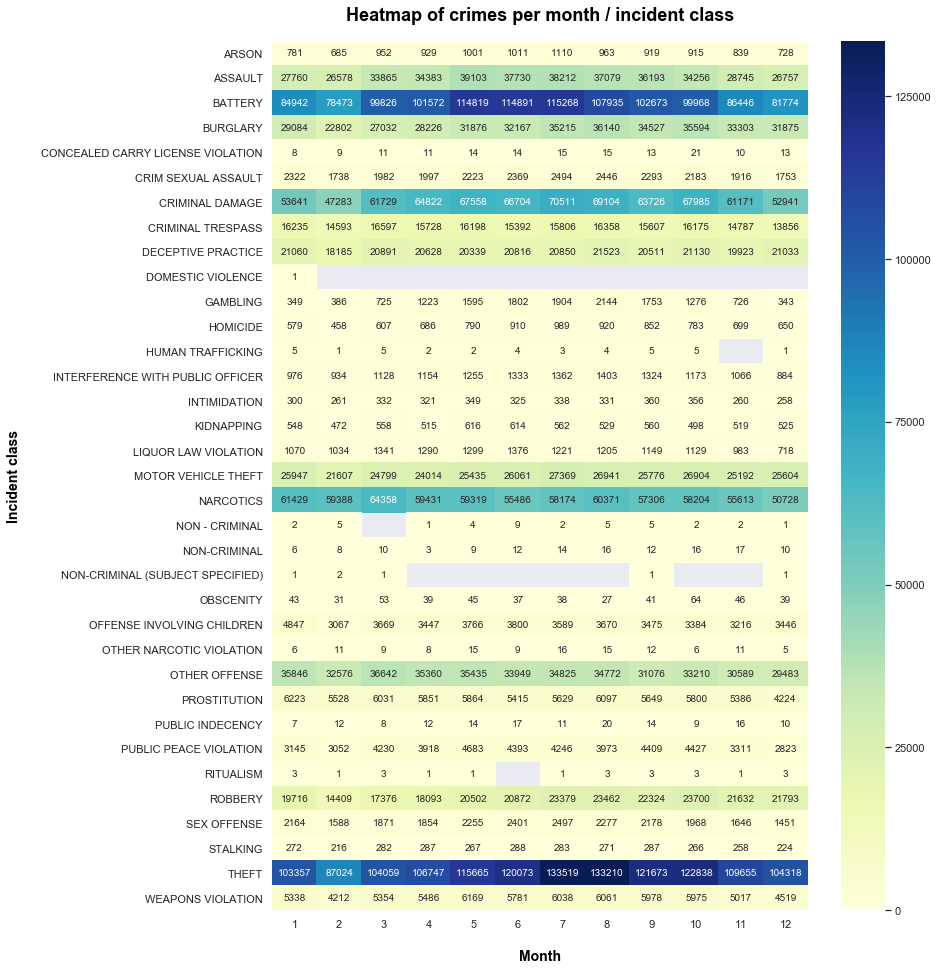

In [24]:
###
# Group our data
##
# Group our data by month
crimes_gb_mpt = crimes_df.groupby(by = ["primary_type", crimes_df.index.month], axis = 0)

# Count the number of incidents of our grouped set
crimes_gb_mpt_count = crimes_gb_mpt["primary_type"].count()

crimes_gb_mpt_count_un = crimes_gb_mpt_count.unstack()

###
# Plot our data
##
plot_main_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 18,
}

plot_axis_title_font = {
    "family": "sans serif",
    "color":  "black",
    "weight": "bold",
    "size": 14,
}

fig, ax = plt.subplots(figsize = (12, 16))
sns.heatmap(data = crimes_gb_mpt_count_un, annot = True, fmt = ".0f", linewidths = .0, center = crimes_gb_mpt_count.max() / 2, cmap = "YlGnBu", ax = ax)

# Set graph title
ax.set_title(label = "Heatmap of crimes per month / incident class", fontdict = plot_main_title_font, pad = 20)

# Set axis proper labels
ax.set_xlabel(xlabel = "Month", fontdict = plot_axis_title_font, labelpad = 20)
ax.set_ylabel("Incident class", fontdict = plot_axis_title_font, labelpad = 20);

Observe how the heatmap reinforces our previous observations i.e. that predominant crime classes are **theft**, **battery**, **criminal damage** and **narcotics** (all highlighted with deeper colors). Also, how seasonality is depicted in the gradient of the colors at the row level, reinforcing our analysis that months **July** and **August** are those when peaks are observed.

### 3 Plotting Geo Data

#### Question

Suppose the Police would like to increase patrols in certain neighborhoods - areas. Officials are asking you "What neighborhoods should we prioritize ?"

Make use of the Geo-related variables in the dataset to find the most "dangerous" neighborhoods and plot the results accordingly.

You can use [Folium](https://python-visualization.github.io/folium/docs-v0.6.0/quickstart.html) (recommended) or [GeoPandas](http://geopandas.org/) for this.

#### Answer

The diversity of the dataset, in terms of aggregated information that can be achieved by grouping at various geographical levels (e.g. community, district etc.) presents us with the problem of striking the correct balance between noise and meaningful, actionable information.

Why not, then, visualize our data at various levels and see what story they tell?

Let us create a generic function that will require the geographical aggregation level and will present us with group points and a heatmap of crime at the specific aggregation level.

Note that since the data, for anonymity purposes, do not provide us with pin-point accuracy in terms of geolocation, we are given the flexibility to assume a flat-earth (?!) situation, where grouping geopoints will be done by simply taking the mean of each component (latitude, longitude).

In [25]:
import matplotlib
import matplotlib.cm as cm

# Required for palette management
from matplotlib.colors import ListedColormap

import folium

# Required for creating the heatmap of crimes
from folium import plugins

def create_heatmap(df, group_by = "district", point_radius = 10, heatmap_radius = 30):
    # Work on our dataset
    # Work on a copy of the original dataframe
    df_c = df.copy(deep = True)
    
    # Exclude 0s
    df_c = df_c[(df_c["latitude"] != 0) & (df_c["longitude"] != 0)]
    
    # Group by the supplied field, perform aggregations
    # and get back our summarized dataframe
    df_c_gb_df = df_c.groupby(by = [group_by], axis = 0).agg({"latitude": ["mean"], "longitude": ["mean"], "primary_type": ["count"]})
    
    # Create an array required for the heatmap plugin
    df_c_gb_df_lat_long_arr = df_c_gb_df[["latitude", "longitude"]].values
    
    # Find the map location start positions
    lat_start = df_c_gb_df["latitude"]["mean"].median()
    long_start = df_c_gb_df["longitude"]["mean"].median()
    
    # Create the map var
    folium_map = folium.Map(
        tiles = "Stamen Toner",
        location = [lat_start, long_start],
        zoom_start = 10
    )
    
    # Create a descriptive string from the group_by argument
    # Will be used for map tooltip display purposes
    geo_aggr_level_name = group_by.replace("_", " ").strip().capitalize()
    
    # Create points on the map
    for i in range(0, len(df_c_gb_df.index)):
        
        lat = df_c_gb_df.loc[df_c_gb_df.index[i], ["latitude", "mean"]][0]
        long = df_c_gb_df.loc[df_c_gb_df.index[i], ["longitude", "mean"]][0]
        geo_area_id = df_c_gb_df.index[i]
        crime_count = df_c_gb_df.loc[df_c_gb_df.index[i], ["primary_type", "count"]][0]
        
        circle_marker = folium.CircleMarker(
            location = [lat, long],
            radius = point_radius,
            tooltip = \
                geo_aggr_level_name + " " + "<strong>" + str(geo_area_id) + "</strong>" + \
                "<hr/>" + \
                "Crime count " + "<strong>" + str(int(crime_count)) + "</strong>",
            color = "#FFFFFF",
            fill = True,
            fill_color = "#000000"
        )
        
        circle_marker.add_to(folium_map);
    
    # Add the heatmap
    folium_map.add_child(plugins.HeatMap(df_c_gb_df_lat_long_arr, radius = heatmap_radius))
    
    return folium_map

In [26]:
# Animated
from datetime import datetime, timedelta

import matplotlib
import matplotlib.cm as cm

# Required for palette management
from matplotlib.colors import ListedColormap

import folium

# Required for creating the heatmap of crimes
from folium import plugins

def create_animated_heatmap(df, group_by = "district", heatmap_radius = 30):
    # Work on our dataset
    # Work on a copy of the original dataframe
    df_c = df.copy(deep = True)
    
    # Exclude 0s
    df_c = df_c[(df_c["latitude"] != 0) & (df_c["longitude"] != 0)]
    
    # Group by the supplied field, perform aggregations
    # and get back our summarized dataframe
    df_c_gb_df = df_c.groupby(by = [df_c.index.year, group_by], axis = 0).agg({"latitude": ["mean"], "longitude": ["mean"], "primary_type": ["count"]})
    
    # Flatten the grouped dataset
    df_map = df_c_gb_df.reset_index()
    
    # Pick the required columns for creating the animated heatmap
    df_map = df_map[["latitude", "longitude", "primary_type", "date"]]
    
    # Create an array of data points required by the animated heatmap plugin
    df_map_data_gb_d = df_map.groupby(by = "date")
    df_map_data_arr = [item.tolist() for item in [df_map_data_gb_d.get_group(g)[["latitude", "longitude", "primary_type"]].values for g in df_map_data_gb_d.groups]]
    
    # Create an array of time intervals required by the animated heatmap plugin
    df_map_time_arr = np.unique(df_map[["date"]].values)
    
    # Flatten and format date from %Y to %Y-%m-%d
    df_map_time_arr = [str(year) + "-01-01" for year in df_map_time_arr]
    
    # Find the map location start positions
    lat_start = df_c_gb_df["latitude"]["mean"].median()
    long_start = df_c_gb_df["longitude"]["mean"].median()
    
    # Create the map var
    folium_map = folium.Map(
        tiles = "Stamen Toner",
        location = [lat_start, long_start],
        zoom_start = 10
    )
    
    heat_map_with_time = plugins.HeatMapWithTime( 
        data = df_map_data_arr,
        index = df_map_time_arr,
        radius = heatmap_radius,
        display_index = True,
        auto_play = True
    )

    heat_map_with_time.add_to(folium_map)
    
    return folium_map

#### Grouping and visualizing crime at various geographical levels

#### Grouping by 'beat'

Indicates the beat where the incident occurred.

A beat is the smallest police geographic area – each beat has a dedicated police beat car. Three to five beats make up a police sector, and three sectors make up a police district. The Chicago Police Department has 22 police districts.

See the beats at https://data.cityofchicago.org/d/aerh-rz74.

Source: [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data)

In [27]:
create_heatmap(crimes_df, group_by = "beat", point_radius = 2, heatmap_radius = 30)

#### Grouping by 'ward'

The ward (City Council district) where the incident occurred.

See the wards at https://data.cityofchicago.org/d/sp34-6z76.

Source: [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data)

In [28]:
create_heatmap(crimes_df, group_by = "ward", point_radius = 2, heatmap_radius = 30)

#### Grouping by 'district'

Indicates the police district where the incident occurred.

See the districts at https://data.cityofchicago.org/d/fthy-xz3r.

Source: [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data)

In [29]:
create_heatmap(crimes_df, group_by = "district", point_radius = 2, heatmap_radius = 30)

#### Grouping by 'communit_area'

Indicates the community area where the incident occurred. Chicago has 77 community areas. 

See the community areas at https://data.cityofchicago.org/d/cauq-8yn6.

Source: [Chicago Crime Crimes Data - 2001 to present](https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2/data)

In [30]:
create_heatmap(crimes_df, group_by = "community_area", point_radius = 2, heatmap_radius = 30)

It appears that the **most meaningful level of aggregation** is at the **dirstrict** level. We can clearly visually identify **3-5 districts** where crime is higher, compared to the rest.

#### Animated concentration of crime at the district level

It is interesting to visualize historical changes in **crime density through time**. Let us plot an animation of our data points at the district level:

In [31]:
create_animated_heatmap(crimes_df, group_by = "district", heatmap_radius = 30)

Examination of historical data shows that, by and large, **concentration of crime remains largely unchanged** at the geographical level with only minor flunctuation occuring at the neighborhood level.

**Bonus**

During your presentation, an officer asks you: "Does the [Pareto Principle](https://en.wikipedia.org/wiki/Pareto_principle) apply to the neighborhoods ?". How would you respond to that ?

#### Answer

We are effectively being asked: "*Does **80%** of crime come from **20%** of the neighbors?*".

In [32]:
def pareto(df, group_by = "district"):
    # Work on our dataset
    # Work on a copy of the original dataframe
    df_c = crimes_df.copy(deep = True)
    
    # Group by the provided geographical level,
    # counting crimes instances
    df_c_gb_pt_df = df_c.groupby(by = [group_by], axis = 0).agg({"primary_type": ["count"]})
    
    # Sort by crimes count, descending
    df_c_gb_pt_df = df_c_gb_pt_df.sort_values(by = ("primary_type", "count"), ascending = False)
    
    # Calculate the percentage of crimes each geographic region
    # contributes to the whole
    df_c_gb_pt_df["percentage"] = df_c_gb_pt_df[("primary_type", "count")] / df_c_gb_pt_df[("primary_type", "count")].sum()
    
    # Calculate the running sum of percentages
    df_c_gb_pt_df["percentage_cumsum"] = df_c_gb_pt_df["percentage"].cumsum()
    
    # Return the percentage of observations up to and including contribution
    # to 80% of cases, divided by the total number of observations.
    return df_c_gb_pt_df[df_c_gb_pt_df["percentage_cumsum"] <= .8].iloc[:, 0].count() / df_c_gb_pt_df.iloc[:, 0].count()

In [33]:
print("Pareto ratio: ", pareto(crimes_df, group_by = "district"))

Pareto ratio:  0.6


We conclude that **~60%** of **districts** are responsible for **~80%** of crime.

Therefore, the Pareto principle **does not apply**.

## Appendix

### Acquiring data by performing SODA API calls

This method could be employed in case we would require a more flexible approach to acquiring data from the City of Chicago API.

In order to use the API, it is preferrable - although not mandatory - to create an API token through the [City of Chicago Data portal](https://data.cityofchicago.org). Registering and acquiring an API token allows for querying the API outside the global anonymous shared resource pool, thus increasing query limits.

In [34]:
# https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
# Create a client to the City of Chicago data source

# Some variables required for accessing the City of Chicago API
domain = "data.cityofchicago.org"
# Ommited for privacy
app_token = "<your_app_token>"
dataset_identifier = "6zsd-86xi"

starting_date = "2001-01-01T00:00:00"

# Dataset throttle control
data_limit = 1000
data_offset = 0

temp_data = []

# The City of Chicago API feeds request utilising a paging mechanism.
# Therefore, we need to provide a way to page our requests to the API by utilising
# 'limit' and 'offset' variables in our query.
# Since there is no clear way for the API to indicate the end-of-data-stream location,
# we need a way to break from the while loop. This will happen when the length of the
# data returned from the API call is 0.

# Initialize the length variable to -1.
data_len = -1

with Socrata(domain=domain, app_token=app_token) as client:
    # Make sure we have the correct data set
    metadata = client.get_metadata(dataset_identifier = dataset_identifier)
    print(metadata["name"])
    print(metadata["description"])
    
    # Extract the dataset column names from the dataset metadata
    data_columns = [x["name"] for x in metadata["columns"]]
    
    while(data_len != 0):
        try:
            # Retrieve paged data, starting from 2010-01-01T00:00:00
            data = client.get(dataset_identifier = dataset_identifier, where = "date >= '" + starting_date + "'", order = "date ASC", content_type = "json", limit = data_limit, offset = data_offset)
            # Append the retrieved data to a temporary array
            temp_data += data
            # Set the offset to the next 'page' of data
            data_offset += 1000
            # Evaluate the data array length so that we know when to break from the while loop
            data_len = len(data)
            print("Data offset: ", data_offset)
        except Exception as e:
            print_stderr(e)
            break
    
    # Convert the entire array of data to a Pandas dataframe
    crimes_df = pd.DataFrame.from_records(data = temp_data)

---